In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from src.utils_py.io.gro import read_gro, write_gro
from src.utils_py.gro.Structure import Structure
from circle_fit import taubinSVD

In [200]:
structure = read_gro(f'data/cal_dw_568_6248.gro')

In [203]:
max, min = 0, structure.box[2]
half_H = structure.box[2] / 2
for a in structure.atoms:
    if a.mol_name in ['CCaa', 'CCa', 'Oca']:
        if a.xyz[2] < half_H and a.xyz[2] > max:
            max = a.xyz[2]
        elif a.xyz[2] > half_H and a.xyz[2] < min:
            min = a.xyz[2]
print(max, min)

2.154 6.057


In [164]:
atoms_xyz = structure.get_XYZ(mol_names=['DECAN'])

(20860, 3)

In [28]:
os.system(f'./mixer -f server_gromos_droplet.gro -o server_gromos_droplet.gro')

0

In [25]:
with open(f'server_gromos_droplet.gro', 'w') as f:
    f.write(write_gro(structure))

In [3]:
def density(structure, type, N, axis=0):
    # N = np.array([100, 150, 100])
    # structure = read_gro(file).apply_pbc()
    structure_copy = structure.copy()
    grid = np.zeros(N)
    half_box = structure_copy.box / 2
    dr = structure_copy.box / N

    # structure_copy.atoms_xyz += half_box
    for a in structure_copy.atoms:
        if (a.mol_name == type):
            try:
                id = np.floor(structure_copy.atoms_xyz[a.id-1] / dr).astype(int)
                id -= (id == N)

                grid[id[0], id[1], id[2]] += 1
            except:
                print(structure_copy.atoms_xyz[a.id-1])
                print(id)
                exit()

    return np.sum(grid, axis=0), dr[(2-axis)//2:(7-axis)//2:(axis%2)+1]

In [3]:
def get_center_pbc(structure, type=None):
    # structure = read_gro(file).apply_pbc()
    atoms_xyz = structure.get_XYZ(mol_names=type)
    theta = atoms_xyz / structure.box * 2 * np.pi
    center = np.zeros(3)

    for i in range(3):
        phi = np.cos(theta[:, i])
        psi = np.sin(theta[:, i])

        phi_mean = np.average(phi)
        psi_mean = np.average(psi)

        theta_mean = np.arctan2(-psi_mean, -phi_mean) + np.pi
        center[i] = structure.box[i] * theta_mean / 2 / np.pi

    return center

In [4]:
def get_border(grid, min=3, max=7):
    border = np.zeros_like(grid).astype(bool)
    shape = grid.shape

    for (i, j) in np.ndindex((shape[0]-2, shape[1]-2)):
        # neigh = (grid[i-1, j+1] > 0) + (grid[i, j+1] > 0) + (grid[i+1, j+1] > 0) + \
        #         (grid[i-1, j] > 0)   +                    + (grid[i+1, j] > 0) + \
        #         (grid[i-1, j-1] > 0) + (grid[i, j-1] > 0) + (grid[i+1, j-1] > 0)

        neigh_list = [grid[i-1, j+1], grid[i, j+1], grid[i+1, j+1], grid[i-1, j], grid[i+1, j], grid[i-1, j-1], grid[i, j-1], grid[i+1, j-1]]
        neigh = sum(map(lambda x: int(x > 0), neigh_list))
        if min < neigh < max:
            border[i, j] = 1
    
    return border

In [5]:
def get_points_from_border(border):
    points = list()

    for (i, j) in np.ndindex(border.shape):
        if border[i, j]:
            points.append(np.array([i, j]))
    
    return np.array(points)

In [6]:
def grid2xyz(grid, dr, box):
    points = list()
    for (i, j) in np.ndindex(grid.shape):
        if grid[i, j]:
            points.append((np.array([i, j]) + 0.5) * dr)
    
    return np.array(points) - box / 2

In [7]:
def points2xyz(points_grid, dr, box):
    points = np.zeros_like(points_grid, dtype=np.float64)
    for i in range(points_grid.shape[0]):
        points[i, :] = (points_grid[i, :] + 0.5) * dr
    
    return points - box / 2

In [13]:
# N = np.ones(3, dtype=int) * 25
structure = read_gro('data/cal_dw_568_6248.gro').apply_pbc()
num = 30
N = np.array([1, num, num])

center = get_center_pbc(structure, type='DECAN')
print(*center)
half_box = structure.box / 2
structure.atoms_xyz -= center
structure.atoms_xyz -= half_box
structure = structure.apply_pbc()
structure.atoms_xyz += half_box

grid, dr = density(structure, 'DECAN', N)
border = get_border(grid, min=3, max=7)
points = get_points_from_border(border)
xc, yc, r, sigma = taubinSVD(points)
print(xc, yc, r, sigma)

atoms_xyz = structure.get_XYZ(mol_names='DECAN')
# plt.figure(figsize=(8, 6))

fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ax[0].scatter(atoms_xyz[:, 1], atoms_xyz[:, 2], s=0.5)
ax[0].set_xlim(0, structure.box[1])
ax[0].set_ylim(0, structure.box[2])
ax[1].imshow(grid)
ax[2].imshow(border)
angle = np.linspace(0, 2*np.pi, 100)
ax[1].plot(xc + r * np.cos(angle), yc + r * np.sin(angle), color='red')
ax[2].plot(xc + r * np.cos(angle), yc + r * np.sin(angle), color='red')

7.702893985201334 2.37585930421679 4.115176252256504


IndexError: index 43 is out of bounds for axis 1 with size 30

[0.19276 0.12116]
-1.4248303771865065 -0.0011310656434464078 1.5782433673662293 0.0979722139358798
1.4371571170765083 0.010807454428469539 1.6054343009085674 0.10531825519121502


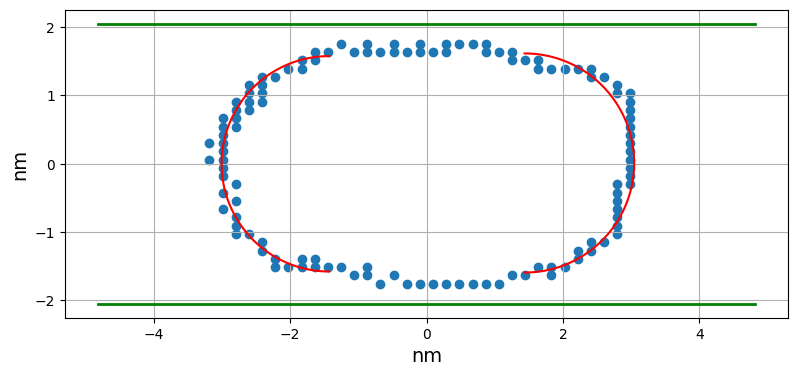

In [13]:
structure = read_gro('data/cal_dw_568_6248.gro').apply_pbc()
num = 50
N = np.array([1, num, num])

center = get_center_pbc(structure, type='DECAN')
half_box = structure.box / 2
for a in structure.atoms:
    a.xyz -= center
    a.xyz += half_box

    structure.atoms_xyz[a.id-1, :] -= center
    structure.atoms_xyz[a.id-1, :] -= half_box
structure = structure.apply_pbc()
for a in structure.atoms:
    a.xyz -= half_box
    structure.atoms_xyz[a.id-1, :] += half_box

grid, dr = density(structure, 'DECAN', N)
print(dr)
border = get_border(grid, min=3, max=7)
grid_points = get_points_from_border(border)
points = points2xyz(grid_points, dr, structure.box[1:])

offset = 1
left_points, right_points = [], []
for i in range(points.shape[0]):
    if points[i, 0] > offset:
        right_points.append(points[i, :])
    elif points[i, 0] < -offset:
        left_points.append(points[i, :])
left_points = np.array(left_points)
right_points = np.array(right_points)

# print(points)
xlc, ylc, rl, sigmal = taubinSVD(left_points)
print(xlc, ylc, rl, sigmal)
xrc, yrc, rr, sigmar = taubinSVD(right_points)
print(xrc, yrc, rr, sigmar)

atoms_xyz = structure.get_XYZ(mol_names='DECAN')
half_H = (6.057 - 2.154) / 2 + 0.1

plt.figure(figsize=(15, 4))
ax = plt.gca()
ax.set_aspect(1)
plt.grid()
plt.xlabel('nm', fontsize=14)
plt.ylabel('nm', fontsize=14)
plt.plot([-half_box[1], half_box[1]], [-half_H, -half_H], linewidth=2, color='green')
plt.plot([-half_box[1], half_box[1]], [half_H, half_H], linewidth=2, color='green')

# plt.scatter(atoms_xyz[:, 1], atoms_xyz[:, 2], s=0.5)
plt.scatter(points[:, 0], points[:, 1])
angle_l = np.linspace(np.pi/2, 3*np.pi/2, 100)
angle_r = np.linspace(3*np.pi/2, 5*np.pi/2, 100)
plt.plot(xlc + rl * np.cos(angle_l), ylc + rl * np.sin(angle_l), color='red')
plt.plot(xrc + rr * np.cos(angle_r), yrc + rr * np.sin(angle_r), color='red')

In [ ]:
# atoms_xyz = structure.get_XYZ(mol_names='DECAN')
# plt.figure(figsize=(8, 6))
# plt.scatter(atoms_xyz[:, 1], atoms_xyz[:, 2], s=0.5)
# # plt.scatter(center[1], center[2])
# plt.scatter(half_box[1], half_box[2])
# plt.xlim(0, structure.box[1])
# plt.ylim(0, structure.box[2])

In [78]:
def get_center(grid, N):
    xv, yv = np.meshgrid(np.arange(N[0]), np.arange(N[1]))

    return np.sum(np.sum(grid * [xv, yv], axis=1), axis=1) / np.sum(grid)

In [79]:
def get_center(file, type=None):
    structure = read_gro(file).apply_pbc()
    atoms_xyz = structure.get_XYZ(mol_names=type)
    return np.average(atoms_xyz, axis=0)

In [9]:
N = np.array([100, 100, 100])
structure = read_gro('data/cal_dw_568_6248.gro').apply_pbc()
grid, dr = density(structure, 'DECAN', N)
atoms_xyz = structure.get_XYZ(mol_names='DECAN')

plt.figure(figsize=(8, 6))
plt.scatter(atoms_xyz[:, 1], atoms_xyz[:, 2], s=0.5)
center = get_center('data/cal_dw_568_6248.gro', type='DECAN')
center_pbc = get_center_pbc(structure, type='DECAN')

plt.scatter(center[1], center[2], color='red')
plt.scatter(center_pbc[1], center_pbc[2], color='yellow')
plt.xlim(0, structure.box[1])
plt.ylim(0, structure.box[2])


IndexError: index 132 is out of bounds for axis 2 with size 100

In [ ]:
CCaa =	3840
OCaa =	11520
Caa	 =  3840

Caa_charge = 1.6689
CCaa_charge = 0.9989
OCaa_charge = -0.889

print(np.float32(Caa_charge*Caa + CCaa_charge*CCaa + OCaa_charge*OCaa))

charge = np.float32(-(Caa_charge*Caa + CCaa_charge*CCaa) / OCaa)
print(charge)

print(np.float32(Caa_charge*Caa + CCaa_charge*CCaa + charge*OCaa))

3.072
-0.88926667
-3.5522462e-05


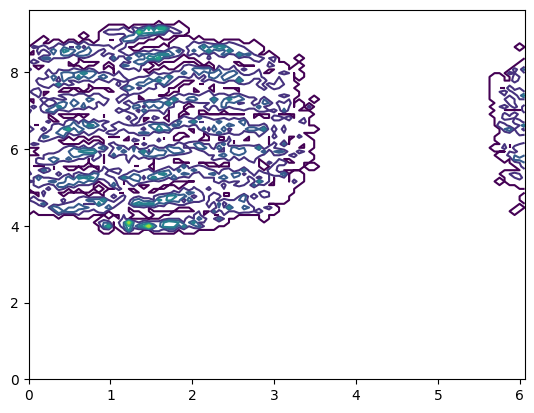

In [224]:
N = np.array([100, 100, 100])
grid, l, dr = density('data/cal_dw_568_6248.gro', 'DECAN', N)
structure = read_gro('data/cal_dw_568_6248.gro').apply_pbc()
atoms_xyz = structure.get_XYZ(mol_names='DECAN')

x = np.linspace(0, structure.box[1], N[1])
y = np.linspace(0, structure.box[2], N[2])
X, Y = np.meshgrid(x, y)
plt.contour(Y, X, grid)

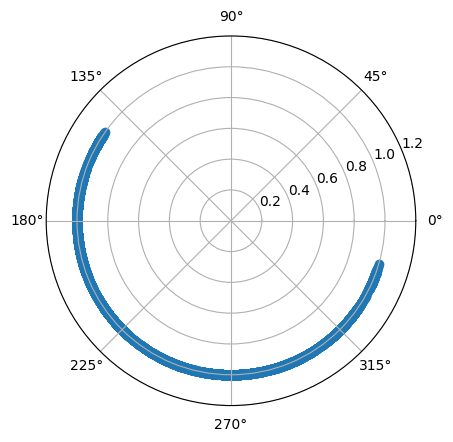

In [216]:
structure = read_gro('data/cal_dw_568_6248.gro').apply_pbc()
atoms_xyz = structure.get_XYZ(mol_names='DECAN')
theta = atoms_xyz / structure.box * 2 * np.pi

axis = 2
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.scatter(theta[:, axis], np.ones_like(theta[:, axis]), color='tab:blue')
ax.set_rmax(1.2)
ax.grid(True)

plt.show()

---

In [33]:
os.system(f'scp mipt-nd:alexey/droplet_silica_gromos/sil_wd_178_595.gro data/sil_wd_178_595.gro')
os.system(f'scp mipt-nd:alexey/droplet_silica_gromos/sil_wd_178_595.xtc data/sil_wd_178_595.xtc')
os.system(f'scp mipt-nd:alexey/droplet_silica_gromos/sil_wd_178_595.tpr data/sil_wd_178_595.tpr')
os.system(f'scp mipt-nd:alexey/droplet_silica_gromos/sil_wd_178_595.edr data/sil_wd_178_595.edr')

0

In [51]:
os.system(f'echo 5 5 | gmx density -f data/cal_dw_568_6248 -s data/cal_dw_568_6248 -o data/density -d Z -sl 1000 -dens number -center -ng 1')
os.system(f'rm data/#*#')

Selected 5: 'DECAN'
Selected 5: 'DECAN'


                  :-) GROMACS - gmx density, 2023-Homebrew (-:

Executable:   /opt/homebrew/bin/../Cellar/gromacs/2023/bin/gmx
Data prefix:  /opt/homebrew/bin/../Cellar/gromacs/2023
Working dir:  /Users/alexey/Dev/MD_conf
Command line:
  gmx density -f data/cal_dw_568_6248 -s data/cal_dw_568_6248 -o data/density -d Z -sl 1000 -dens number -center -ng 1

Reading file data/cal_dw_568_6248.tpr, VERSION 2019.2 (single precision)

Note: that the center of mass is calculated inside the box without applying
any special periodicity. If necessary, it is your responsibility to first use
trjconv to make sure atoms in this group are placed in the right periodicity.

Select the group to center density profiles around:
Group     0 (         System) has 43624 elements
Group     1 (          Other) has 43624 elements
Group     2 (           CCaa) has  3840 elements
Group     3 (           OCaa) has 11520 elements
Group     4 (            Caa) has  3840 elements
Group     5 (          DECAN) has  5680 

0

58.921703933535554

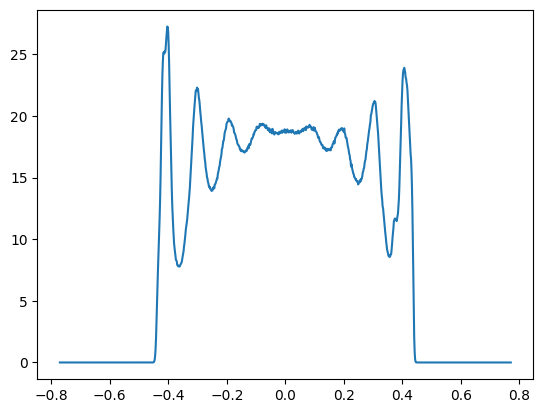

In [101]:
z, dens = np.loadtxt("data/density.xvg",comments=["@", "#"],unpack=True)
plt.plot(z / 3.928, dens)
np.trapz(dens, z)

In [22]:
y, dens_CCaa, dens_OCaa, dens_Caa = np.loadtxt("data/density.xvg",comments=["@", "#"],unpack=True)
plt.figure(figsize=(8, 6))
plt.grid()
# ax = plt.gca()
# ax.set_aspect(1)
plt.plot(y, dens_CCaa, label='C')
plt.plot(y, dens_OCaa, label='O')
plt.plot(y, dens_Caa, label='Ca')
plt.legend(fontsize=14)
# plt.plot(y, dens_Caa + dens_OCaa + dens_Caa)
# plt.ylim(bottom=3)


ValueError: not enough values to unpack (expected 4, got 2)

In [ ]:
os.system('ssh mipt-nd:alexey/trappe_test/cal_3.9_0.5_2.1_unchanged')

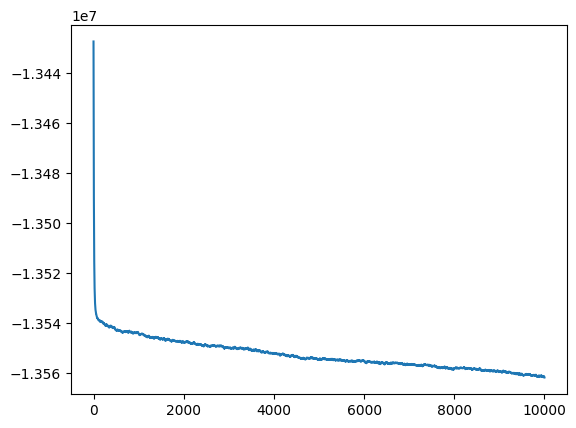

In [100]:
y, eng = np.loadtxt("data/energy.xvg",comments=["@", "#"],unpack=True)
plt.plot(y, eng)

---
### Tests

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(0.0, 1.0)

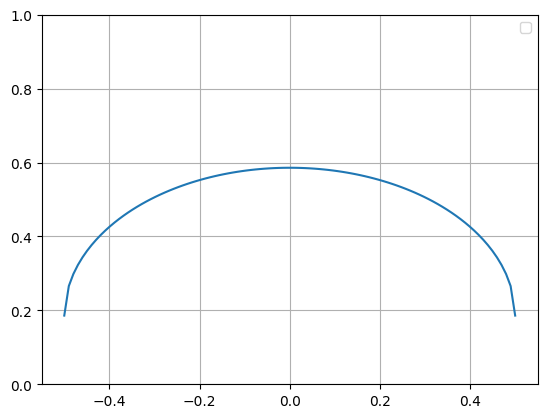

In [12]:
z = np.linspace(0, 1, 100)
z_abs = z - 0.5
plt.grid()
# plt.plot(z-0.5, rho(z, 2.5, 0.5, np.pi / 3))

# for theta in [np.pi / 2 - 0.01, np.pi / 2, np.pi / 2 + 0.01]:
#     plt.plot(z_abs, rho(z_abs, 2.5, 0.5, theta), label=r'$\theta$='+'{:.2f}'.format(np.rad2deg(theta)), color='red', alpha=0.4)
#     plt.plot(z_abs, rho_approx(z_abs, 2.5, 0.5, theta), label=r'$\theta$='+'{:.2f}'.format(np.rad2deg(theta)), color='blue', alpha=0.4)
# plt.plot(z_abs, (0.5 + np.sqrt(1 - 4 * z_abs**2) / 2.5 - np.pi / 4 / 2.5))
plt.plot(z_abs, rho_approx(z_abs, 2.5, 0.5, np.pi))
plt.legend()
plt.ylim(0, 1)
# print(np.trapz(rhon(z_abs, 2.5, 0.5, np.pi / 3), z_abs))

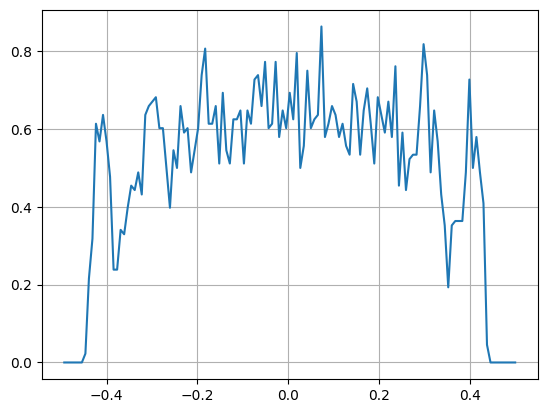

In [43]:
structure = read_gro('data/cal_dw_568_6248.gro').apply_pbc()
N = 200
z, dens, dr = density_profile(structure, 'DECAN', N)
center = np.trapz(dens * z, z) / np.trapz(dens, z)
z -= center
new_index = np.argsort(z)
z = z[new_index]
dens = dens[new_index]
H = 3.928
z /= H
dens /= 2 * np.trapz(dens, z)
# plt.plot(z / 3.928, dens)

new_z, new_dens = [], []
for i, zi in np.ndenumerate(z):
    if np.abs(zi) <= 0.5:
        new_z.append(zi)
        new_dens.append(dens[i])

z = np.array(new_z)
dens = np.array(new_dens)

plt.plot(z, dens)
# plt.vlines(center, 0, 20)
plt.grid()

---

# ROLL

In [19]:
def rho_approx(zeta, l, phi, theta):
    if np.abs(theta - np.pi / 2) < 0.5:
            return phi - (1 - 120 * zeta**2 + 720 * zeta**4) * (theta - np.pi / 2)**3 / 360 / l - (12 * zeta**2 - 1) * (theta - np.pi / 2) / 6 / l

    return (phi * l - (2 * theta - np.pi) / 4 / np.cos(theta)**2 + np.sign(2 * theta - np.pi) * np.sqrt(1 / np.cos(theta)**2 - 4 * zeta**2) + np.tan(theta) / 2) / l

In [4]:
def density_profile(structure, type, N, axis=2):
    # N = np.array([100, 150, 100])
    # structure = read_gro(file).apply_pbc()
    structure_copy = structure.copy()
    profile = np.zeros(N)
    ax, dr = np.linspace(0, structure_copy.box[axis], N, retstep=True)
    S = np.prod(structure_copy.box[(2-axis)//2:(7-axis)//2:(axis%2)+1])

    # structure_copy.atoms_xyz += half_box
    for a in structure_copy.atoms:
        if (a.mol_name == type):
            id = np.floor(structure_copy.atoms_xyz[a.id-1][axis] / dr).astype(int)
            id -= (id == N)

            profile[id] += 1

    return ax, profile / (S * dr), dr

In [10]:
from hyperopt import fmin, tpe, hp, Trials

6.7848532436838145


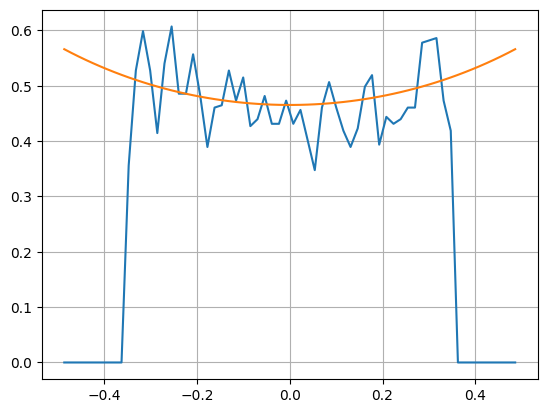

In [113]:
angle = 60
z, dens = np.loadtxt(f"na_diff/angles/density/density_{angle}.xvg", comments=["@", "#"], unpack=True)
H = 3.928
z /= H
offset = 0.15
z_cut = []
dens_cut = []

new_z, new_dens = [], []
for i, zi in enumerate(z):
    if np.abs(zi) <= 0.5 - offset:
        new_z.append(zi)
        z_cut.append(zi)
        new_dens.append(dens[i])
        dens_cut.append(dens[i])
    elif np.abs(zi) <= 0.5:
        new_z.append(zi)
        new_dens.append(0)

z = np.array(new_z)
z_cut = np.array(z_cut)

dens = np.array(new_dens)
# print(np.trapz(dens, z))
dens /= np.trapz(dens, z)
dens *= np.trapz(rho_approx(z_cut, 2.5, 0.5, np.deg2rad(angle)), z_cut)

dens_cut = np.array(dens_cut)
# print(np.trapz(dens, z))
dens_cut /= np.trapz(dens_cut, z_cut)
dens_cut *= np.trapz(rho_approx(z_cut, 2.5, 0.5, np.deg2rad(angle)), z_cut)

print(error(z, dens, np.deg2rad(15)))

plt.plot(z, dens)
plt.plot(z, rho_approx(z, 2.5, 0.5, np.deg2rad(angle)))

plt.grid()

In [31]:
def error(z, dens, angle):
    return np.sum((rho_approx(z, 2.5, 0.5, angle) - dens)**2)

In [72]:
def objective(args):
    global z_cut, dens_cut
    return np.sum((rho_approx(z_cut, 2.5, 0.5, args['theta']) - dens_cut)**2)

In [118]:
angle = 60
H = 3.928
offset = 0.125

def objective(args):
    z, dens = np.loadtxt(f"na_diff/angles/density/density_{angle}.xvg", comments=["@", "#"], unpack=True)
    z /= H

    new_z, new_dens = [], []
    for i, zi in enumerate(z):
        if np.abs(zi) <= 0.5 - offset:
            new_z.append(zi)
            new_dens.append(dens[i])
    z = np.array(new_z)
    dens = np.array(new_dens)
    dens /= np.trapz(dens, z)
    dens *= np.trapz(rho_approx(z, 2.5, 0.5, args['theta']), z)

    return np.sum((rho_approx(z, 2.5, 0.5, args['theta']) - dens)**2)

In [119]:
trials = Trials()
space = {
    'theta': hp.uniform('theta', 0, np.pi)
}

best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=1000,
    trials=trials,
    show_progressbar=True
)

100%|██████████| 1000/1000 [00:02<00:00, 497.63trial/s, best loss: 0.22581416883584843]


In [120]:
np.rad2deg(best['theta'])

61.19047275535087

In [123]:
for angle in range(15, 166, 15):
    H = 3.928
    offset = 0.125

    def objective(args):
        z, dens = np.loadtxt(f"na_diff/angles/density/density_{angle}.xvg", comments=["@", "#"], unpack=True)
        z /= H

        new_z, new_dens = [], []
        for i, zi in enumerate(z):
            if np.abs(zi) <= 0.5 - offset:
                new_z.append(zi)
                new_dens.append(dens[i])
        z = np.array(new_z)
        dens = np.array(new_dens)
        dens /= np.trapz(dens, z)
        dens *= np.trapz(rho_approx(z, 2.5, 0.5, args['theta']), z)

        return np.sum((rho_approx(z, 2.5, 0.5, args['theta']) - dens)**2)
    
    trials = Trials()
    space = {
        'theta': hp.uniform('theta', 0, np.pi)
    }

    best = fmin(
        fn=objective,
        space=space,
        algo=tpe.suggest,
        max_evals=1000,
        trials=trials,
        show_progressbar=False
    )

    print(angle, ':', np.rad2deg(best['theta']))

100%|██████████| 1000/1000 [00:02<00:00, 452.65trial/s, best loss: 0.23038903855224935]
15 : 43.778663937928236
100%|██████████| 1000/1000 [00:02<00:00, 469.44trial/s, best loss: 0.15956230270984206]
30 : 59.874916211855144
100%|██████████| 1000/1000 [00:02<00:00, 478.74trial/s, best loss: 0.2231095733961848]
45 : 38.68984642596379
100%|██████████| 1000/1000 [00:02<00:00, 487.39trial/s, best loss: 0.22581416631839435]
60 : 61.233830920268446
100%|██████████| 1000/1000 [00:02<00:00, 484.93trial/s, best loss: 0.1740162015764893] 
75 : 89.47894175608269
100%|██████████| 1000/1000 [00:02<00:00, 470.38trial/s, best loss: 0.199772094670347] 
90 : 83.60591247895003
100%|██████████| 1000/1000 [00:02<00:00, 459.52trial/s, best loss: 0.18153455325673867]
105 : 105.6950156170455
100%|██████████| 1000/1000 [00:02<00:00, 481.53trial/s, best loss: 0.25429235297078023]
120 : 114.29622786955721
100%|██████████| 1000/1000 [00:02<00:00, 491.54trial/s, best loss: 0.30219405595858007]
135 : 155.6530570141

(-0.5, 0.5)

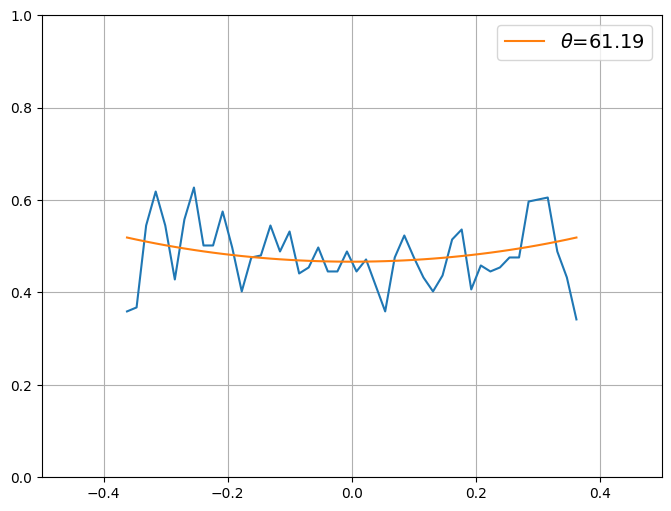

In [121]:
z, dens = np.loadtxt(f"na_diff/angles/density/density_{angle}.xvg", comments=["@", "#"], unpack=True)
z /= H

new_z, new_dens = [], []
for i, zi in enumerate(z):
    if np.abs(zi) <= 0.5 - offset:
        new_z.append(zi)
        new_dens.append(dens[i])
z = np.array(new_z)
dens = np.array(new_dens)
dens /= np.trapz(dens, z)
dens *= np.trapz(rho_approx(z, 2.5, 0.5, best['theta']), z)

plt.figure(figsize=(8, 6))
plt.grid()
plt.plot(z, dens)
plt.plot(z, rho_approx(z, 2.5, 0.5, best['theta']), label=r'$\theta$='+'{:.2f}'.format(np.rad2deg(best['theta'])))
plt.legend(fontsize=14)
# print(np.trapz(rho(z+0.5, 2.5, 0.5, np.pi/3), z))
plt.ylim(0, 1)
plt.xlim(-0.5, 0.5)